#   AE 238 ASSIGNMENT 2
### _Submitted By Vighnesh JR_ <br>
Roll No: $210010073$

## Truss building code

In [1]:
"""
Plane Truss Analysis
Version 1

Amuthan Ramabathiran
January 2023

AE 238: Aerospace Structural Mechanics
"""

import numpy as np
import matplotlib.pyplot as plt

class PlaneTruss:
    def __init__(self, joints, members, E, A):
        self.dim = 2

        self.joints = joints
        self.members = members

        self.n_joints = len(joints)
        self.n_members = len(members)

        if type(E) == np.ndarray:
            self.Es = np.array(E)
        else:
            self.Es = E*np.ones(self.n_members)

        if type(A) == np.ndarray:
            self.As = np.array(A)
        else:
            self.As = A*np.ones(self.n_members)

        self.Ls = self.compute_lengths()
        self.thetas = self.compute_angles()

        self.n_dofs = self.dim*self.n_joints
        self.dofs = np.array([np.nan for _ in range(self.n_dofs)])

        self.K = np.zeros((self.n_dofs, self.n_dofs))
        self.F = np.zeros(self.n_dofs)

    def length(self, idx):
        id1, id2 = self.members[idx]
        coords1 = self.joints[id1]
        coords2 = self.joints[id2]
        return np.sqrt(np.sum((coords2 - coords1)**2))

    def angle(self, idx):
        L = self.length(idx)
        id1, id2 = self.members[idx]
        coords1 = self.joints[id1]
        coords2 = self.joints[id2]
        dx = coords2[0] - coords1[0]
        return np.arccos(dx/L)

    def compute_lengths(self):
        Ls = np.zeros(self.n_members)
        for i in range(self.n_members):
            Ls[i] = self.length(i)
        return Ls

    def compute_angles(self):
        thetas = np.zeros(self.n_members)
        for i in range(self.n_members):
            thetas[i] = self.angle(i)
        return thetas

    def apply_constraints(self, constraints):
        for c in constraints:
            self.dofs[self.dim*c[0] + c[1]] = c[2]

    def apply_loads(self, loads):
        for l in loads:
            self.F[self.dim*l[0] + l[1]] = l[2]

    def member_stiffness(self, idx):
        K = np.zeros((4, 4))
        c = np.cos(self.thetas[idx])
        s = np.sin(self.thetas[idx])

        K[0, 0] = c*c
        K[0, 1] = c*s
        K[0, 2] = -c*c
        K[0, 3] = -c*s

        K[1, 0] = c*s
        K[1, 1] = s*s
        K[1, 2] = -c*s
        K[1, 3] = -s*s

        K[2, 0] = -c*c
        K[2, 1] = -c*s
        K[2, 2] = c*c
        K[2, 3] = c*s

        K[3, 0] = -c*s
        K[3, 1] = -s*s
        K[3, 2] = c*s
        K[3, 3] = s*s

        return self.Es[idx]*self.As[idx]*K/self.Ls[idx]

    def compute_stiffness(self):
        for i in range(self.n_members):
            K_member = self.member_stiffness(i)

            id1, id2 = self.members[i]
            ids = []
            ids.append(self.dim*id1)
            ids.append(self.dim*id1 + 1)
            ids.append(self.dim*id2)
            ids.append(self.dim*id2 + 1)

            for j in range(2*self.dim):
                for k in range(2*self.dim):
                    self.K[ids[j], ids[k]] += K_member[j, k]

    def enforce_constraints(self):
        n_support = 0
        K_support = []

        for i in range(self.n_dofs):
            if not np.isnan(self.dofs[i]):
                n_support += 1
                K_support.append(np.array(self.K[i]))
                for j in range(self.n_dofs):
                    if j == i:
                        self.K[i, j] = 1.0
                    else:
                        self.K[i, j] = 0.0

        self.n_support = n_support
        self.K_support = np.array(K_support)

    def compute_reactions(self):
        reactions = np.zeros(self.n_support)
        for i in range(self.n_support):
            reactions[i] = self.K_support[i] @ self.dofs
        self.reactions = reactions

    def compute_member_forces(self):
        member_forces = np.zeros(self.n_members)
        for i in range(self.n_members):
            id1, id2 = self.members[i]
            u1 = self.dofs[self.dim*id1 + 0]
            v1 = self.dofs[self.dim*id1 + 1]
            u2 = self.dofs[self.dim*id2 + 0]
            v2 = self.dofs[self.dim*id2 + 1]
            d1 = u1*np.cos(self.thetas[i]) + v1*np.sin(self.thetas[i])
            d2 = u2*np.cos(self.thetas[i]) + v2*np.sin(self.thetas[i])
            member_forces[i] = self.Es[i]*self.As[i]*(d2 - d1)/self.Ls[i]
        self.member_forces = member_forces

    def solve(self):
        self.compute_stiffness()
        self.enforce_constraints()

        self.dofs = np.linalg.solve(self.K, self.F)

        self.compute_reactions()
        self.compute_member_forces()


    def plot(self, deformed=True, mag=25):
        TOL = 1e-6
        fig = plt.figure(figsize=(6, 6))

        for i in range(self.n_members):
            id1, id2 = self.members[i]
            plt.plot(
                [self.joints[id1, 0], self.joints[id2, 0]],
                [self.joints[id1, 1], self.joints[id2, 1]],
                '-', color='gray', linewidth=5)

        plt.scatter(self.joints[:, 0], self.joints[:, 1], c='b', s=20)

        if deformed:
            for i in range(self.n_members):
                id1, id2 = self.members[i]
                x1 = self.joints[id1, 0] + mag*self.dofs[2*id1 + 0]
                y1 = self.joints[id1, 1] + mag*self.dofs[2*id1 + 1]
                x2 = self.joints[id2, 0] + mag*self.dofs[2*id2 + 0]
                y2 = self.joints[id2, 1] + mag*self.dofs[2*id2 + 1]

                color = 'black'
                if self.member_forces[i] > TOL:
                    color = 'blue'
                elif self.member_forces[i] < -TOL:
                    color = 'red'

                plt.plot(
                    [x1, x2], [y1, y2],
                    '-', color=color, linewidth=3)

        plt.show()




## Question 1

### Part 1:
In the given problem we have **6 joints** , **9 members** , and **3(2 + 1)** unknown **Reaction forces**. Chceking the compatibility equation $$2j = m + r$$ , We have $2 \times (j = 6 ) =  (m =9 ) + (r =3)$ , Which is perfectly valid for the given truss , hence the truss is **Statically determinable**

### Part 2:
We are going to break down the truss into joints and members . Now lets number these entities 

#### 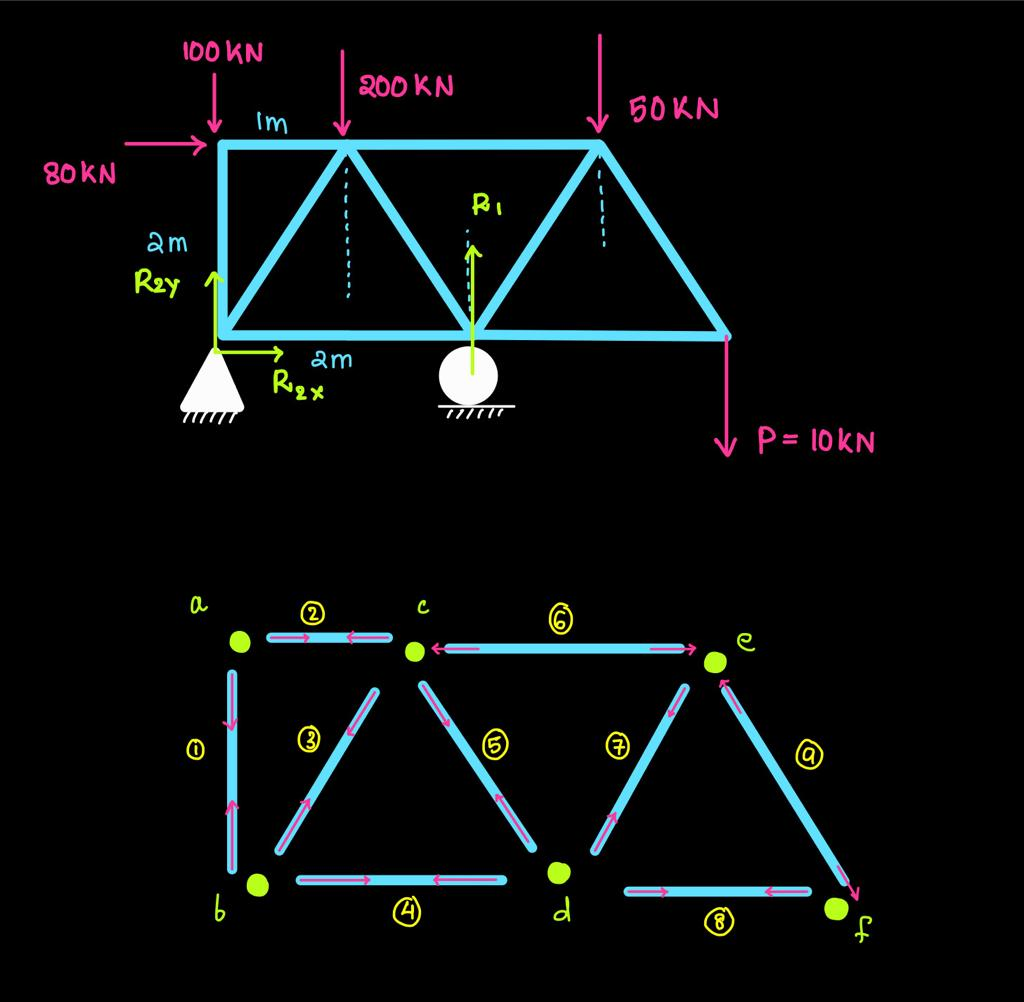

Let the compressive or tensile force in the $i^{th}$ rod be $F_i$ , and here the directions are assumed on a pre solved or intuitive basis.<br>
Analysing the equilibrium of **joint a** , we have $F_1 = 100kN$ and $F_2 = 08kN$ <BR> 
    Assuming P =10kN , we consider the equilibrium of joint f and we have $F_9 = \frac{P}{cos\theta}$ and $F_8 = Ptan\theta$ where $\theta$ is the angle between rod 1 and 3 or half the angle between rod 3 and 5 or 5 and 7 or 7 and 9. Now apply equilibrium conditions on each junction to get rod forces.


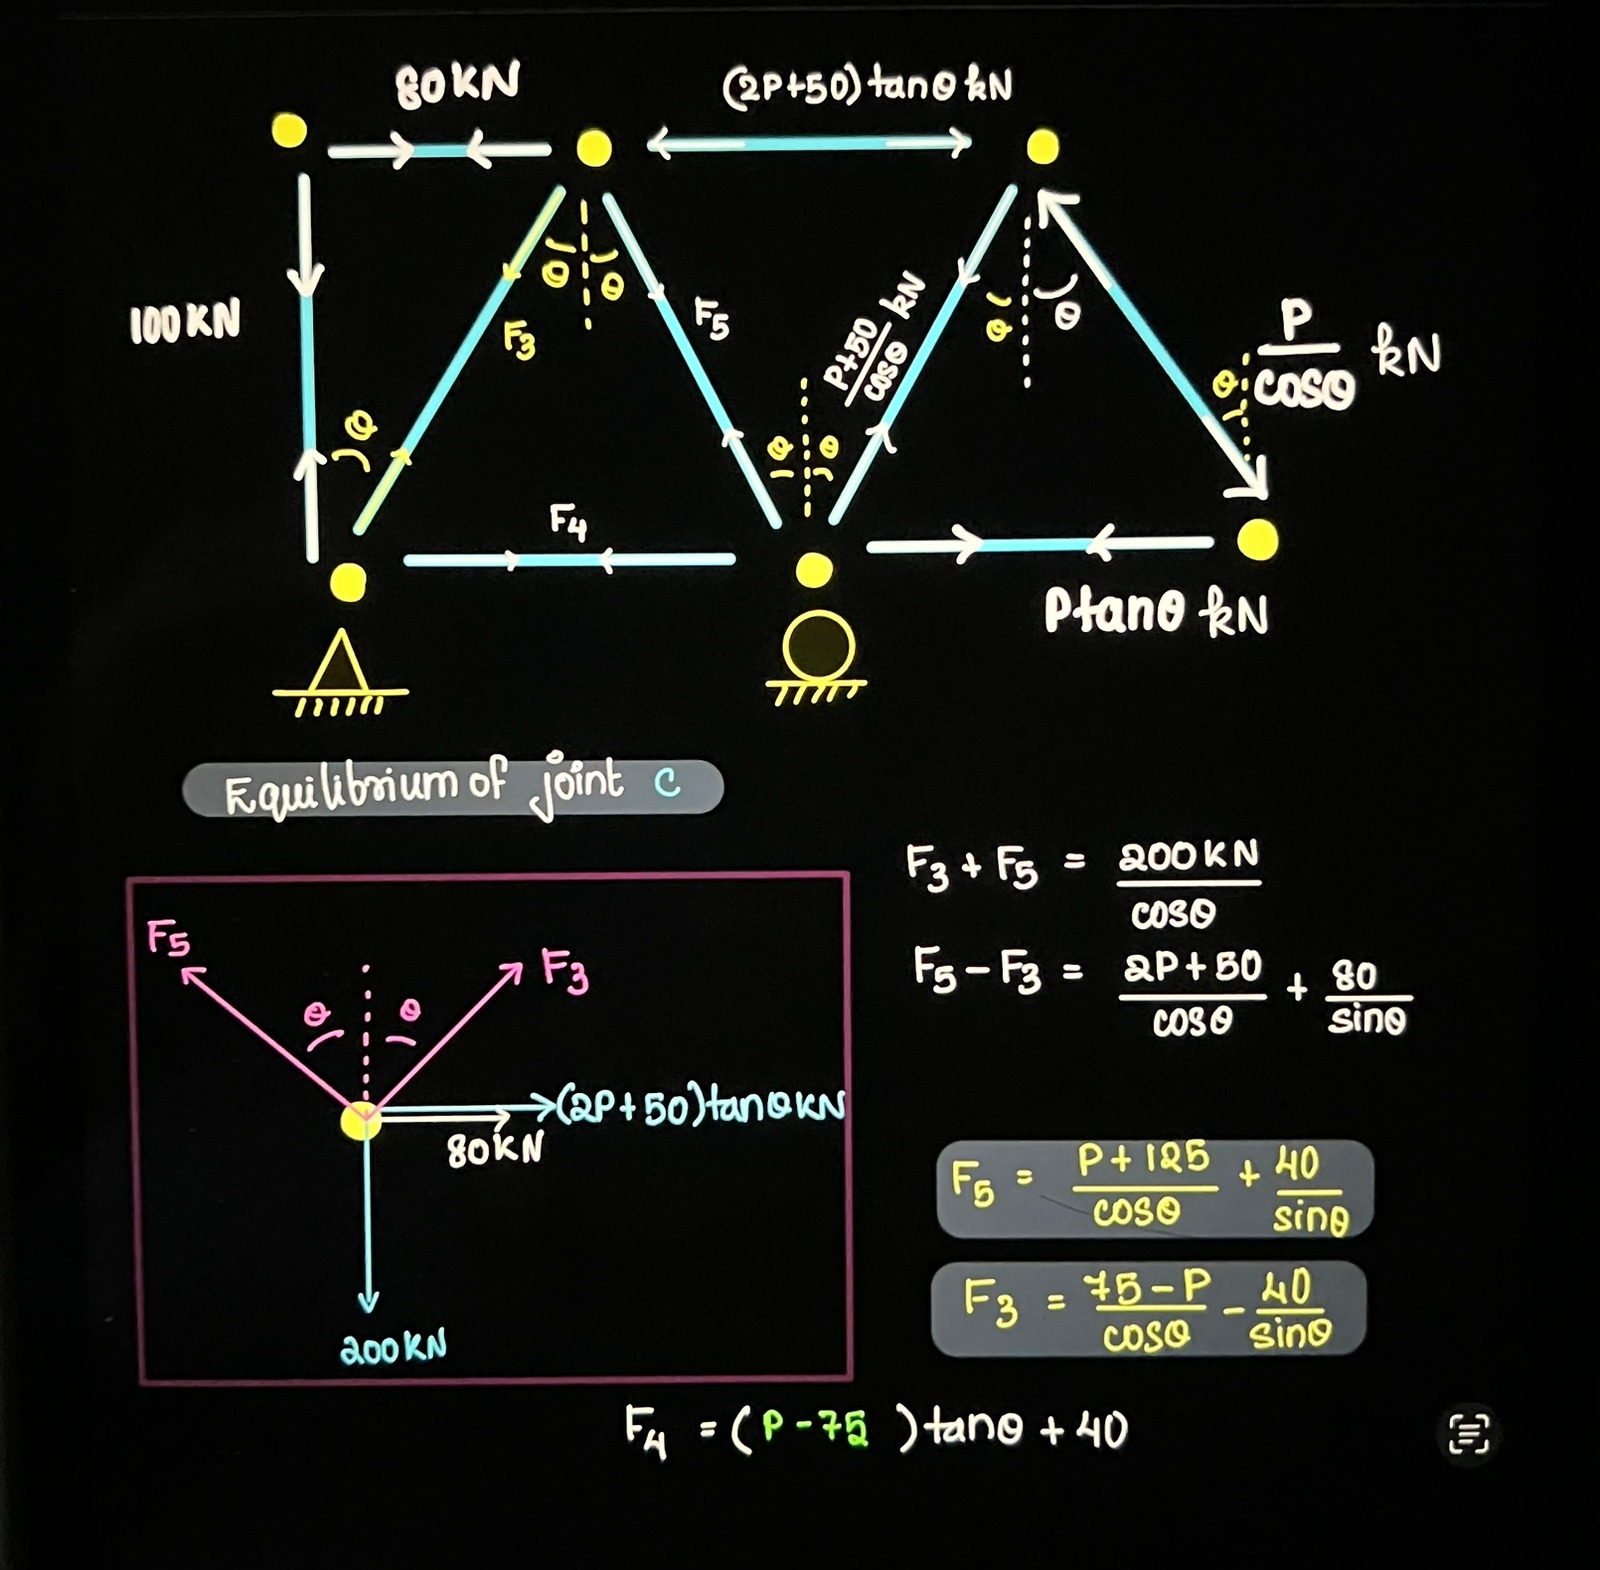

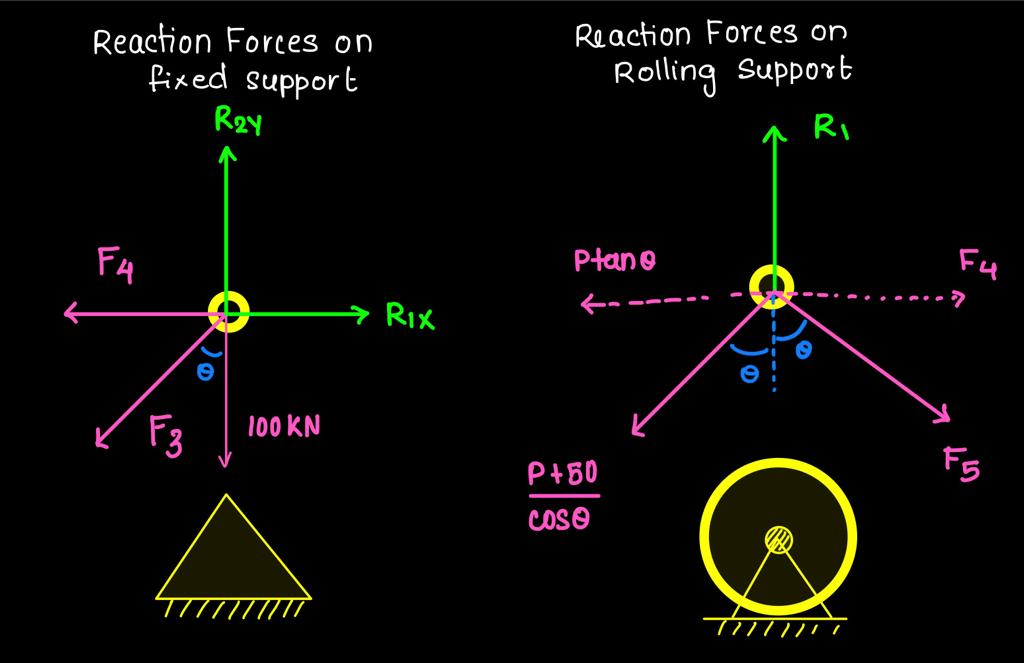

Now all the above forces are labeled in terms of P. Since we have expression for the member internal forces we can compute the support reaction forces also


$$F_1 = 100KN$$
$$F_2 = 80KN$$
$$F_3 = -16.7705098312 KN$$
$$F_4 = 42.5KN$$
$$F_5=240.377307581kN$$
$$F_6 = 35 KN$$
$$F_7 = 67.082039325KN$$
$$F_8 = 5KN$$
$$F_9 = 11.1803398875 KN$$
Above are the member forces

### Part 3:
Using code to check the truss forces values 

In [2]:
"""
simple truss example libraby way
"""
import numpy as np
import plane_truss_lib as amu


Creating the truss by mentioning the joints and members

In [3]:
joints = np.array([ [0.0,0.0],[2.0,0.0],[4.0,0.0],[0.0,2.0],[1.0,2.0],[3.0,2.0]])
members =np.array([[0,1],[1,2],[0,3],[3,4],[4,5],[0,4],[1,4],[1,5],[2,5]],dtype=int)
E=2.1e11
A= np.pi * (2.5e-2)*(2.5e-2)

Checking the formation of the truss

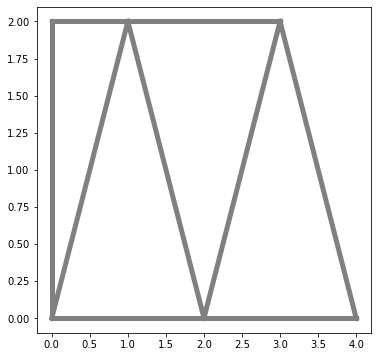

In [4]:
truss = amu.PlaneTruss(joints, members, E, A)
truss.plot(deformed=False) #reality check

Setting constraints 

In [5]:
constraints = [
        [0, 0, 0.0], #node 0 , directon 0 displacement =0.0
        [0, 1, 0.0], #node 0 , direction 1 disp =0.0
        [1, 1, 0.0], #node 3 direction 0 disp =0.0 
    ]
truss.apply_constraints(constraints)

Setting Loads

In [6]:
loads = [
        [3, 0, 80e3], #node 1 , direction 0 force 80kN
        [3, 1, -100e3],#node 1 , direction 1 force -100kN
        [4,1,-200e3],
        [5,1,-50e3],
        [2,1,-10e3] #node 5 variable force P=10kN is acted downwards
    
    ]
truss.apply_loads(loads)


Solving the truss

In [7]:
truss.solve() 

In [8]:
truss.member_forces #shows the internal member forces

array([  72500.        ,   -5000.        , -100000.        ,
        -80000.        ,   35000.        ,   16770.50983125,
       -240377.30758123,  -67082.03932499,   11180.3398875 ])

Here all member forces are considered in tensile direction (hence sign convention) and they are a perfect match with hand calcuated values

In [9]:
truss.reactions #support reactions (R2x,R2y,R1)

array([-80000.,  85000., 275000.])

In [10]:
truss.dofs #displacement of joints

array([ 2.04605357e-20, -2.60970560e-20,  3.51656636e-04, -5.27612615e-20,
        3.27404454e-04, -2.03967031e-03,  1.92894468e-03, -4.85043636e-04,
        1.73492722e-03, -7.65783248e-04,  1.90469250e-03, -1.18323938e-03])

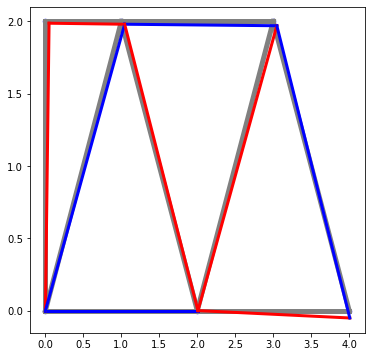

In [11]:

truss.plot()

_Above is the deformation diagram of the truss_

**CONCLUSION** : Code output and hand calculated  match and deformations can be seen <br>
member 0 is $F_4$ , member 1 is $F_8$ , memeber 2 is $F_1$ , member 3 is $F_2$ , memeber 4 is $F_6$ , member 5 is $F_3$ , member 6 is $F_5$ ,memeber 7 is $F_7$ and member 8 is $F_9$

### Part 4:
From the FBD in _part 2_ we know that $$F_6 = P + 25$$
$$F_7 = \frac{\sqrt{5}}{2}(P+50)$$
$$F_8 = \frac{P}{2}$$
$$F_3 = \frac{\sqrt{5}}{2}(75-P) -40\sqrt5$$
$$F_5 =  \frac{\sqrt{5}}{2}(P+125) +40\sqrt5$$
$$F_4 = \frac{1}{2}(P -75) -40$$
$$F_9 =  \frac{\sqrt{5}}{2}P$$
Above are the member forces that depend on variable force P. From the given data the maximum toleratable stress or breaking stress ( tensile) is 785398.163397 N or 785.39816kN

In [12]:
joints = np.array([ [0.0,0.0],[2.0,0.0],[4.0,0.0],[0.0,2.0],[1.0,2.0],[3.0,2.0]])
members =np.array([[0,1],[1,2],[0,3],[3,4],[4,5],[0,4],[1,4],[1,5],[2,5]],dtype=int)
E=2.1e11
A= np.pi * (2.5e-2)*(2.5e-2)

def Fs(P):
    constraints = [
        [0, 0, 0.0], #node 0 , directon 0 displacement =0.0
        [0, 1, 0.0], #node 0 , direction 1 disp =0.0
        [1, 1, 0.0], #node 3 direction 0 disp =0.0 
    ]
    trussy = amu.PlaneTruss(joints, members, E, A)
    trussy.apply_constraints(constraints)
    loads = [
        [3, 0, 80e3], #node 1 , direction 0 force 80kN
        [3, 1, -100e3],#node 1 , direction 1 force -100kN
        [4,1,-200e3],
        [5,1,-50e3],
        [2,1,-P*(1e3)] #node 5 variable force P=10kN is acted downwards
    
    ]
    trussy.apply_loads(loads)
    trussy.solve()
    a=trussy.member_forces
    return np.array([a[4],a[0],a[1],a[7],a[5],a[6],a[8]])/1000

    

Fs(P) : where P is in KN returns $F_6$ $F_4$ $F_8$ $F_7$  $F_3$ $F_5 $and $F_9$ in order in KN as tensile forces

In [13]:
ps = np.linspace(-1000,1000,20001)
f6=[]
f4=[]
f8=[]
f7=[]
f3=[]
f5=[]
f9=[]
for p in ps:
    a=Fs(p)
    f6.append(a[0])
    f4.append(a[1])
    f8.append(a[2])
    f7.append(a[3])
    f3.append(a[4])
    f5.append(a[5])
    f9.append(a[6])


In [14]:
import matplotlib.pyplot as plt
fail =  785.398163397*np.ones_like(ps)

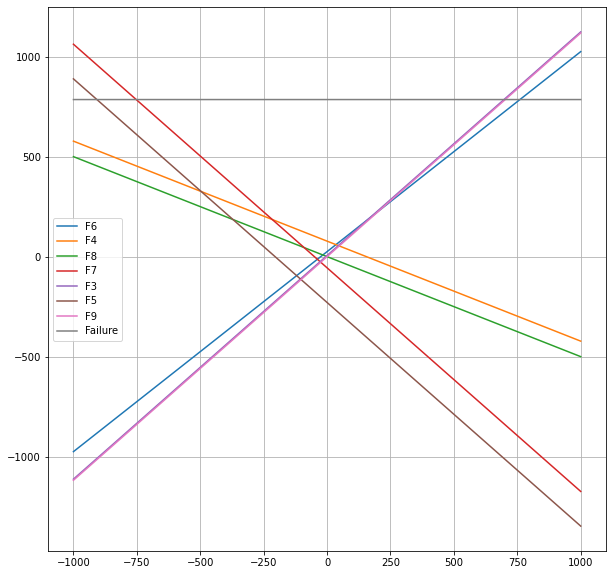

In [15]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.plot(ps,f6)
plt.plot(ps,f4)
plt.plot(ps,f8)
plt.plot(ps,f7)
plt.plot(ps,f3)
plt.plot(ps,f5)
plt.plot(ps,f9)
plt.plot(ps,fail)
plt.legend(["F6","F4","F8","F7","F3","F5","F9","Failure" ])
plt.grid()
#plt.axis("equal")

From the above plot we can see that $F_3$ member rod fails first for postive value of P and $F_7$ member rod fails first for negative value of P demarking the upper and lower bounds on P. Using formulas for $F_3$ and $F_7$ we can get the limits of P for saftey of the truss

From calculations we have $$-\frac{\sqrt5}{2}(P_{min}+50) =785.398163397 kN$$
$$\frac{\sqrt{5}}{2}(P_{max}-75) +40\sqrt5=785.398163397 kN$$


$P_{min}= -752.48147 kN$ and $P_{max}  = 697.4814731 kN$ and P should lie between these two values for saftey of the truss

## Question 2

### Part 1:
The truss has 8 joints , 4 reactions ( 2 fixed supports ) and 16 member rods and if we check the formula $2j = m + r$ its fails as $2 \times 8 \neq 16 + 4$ , hence the truss is **statically indeterminate**

### Part 2: Solving the truss
We are going to consider a schematic numbered truss diagram and build and solve it using code

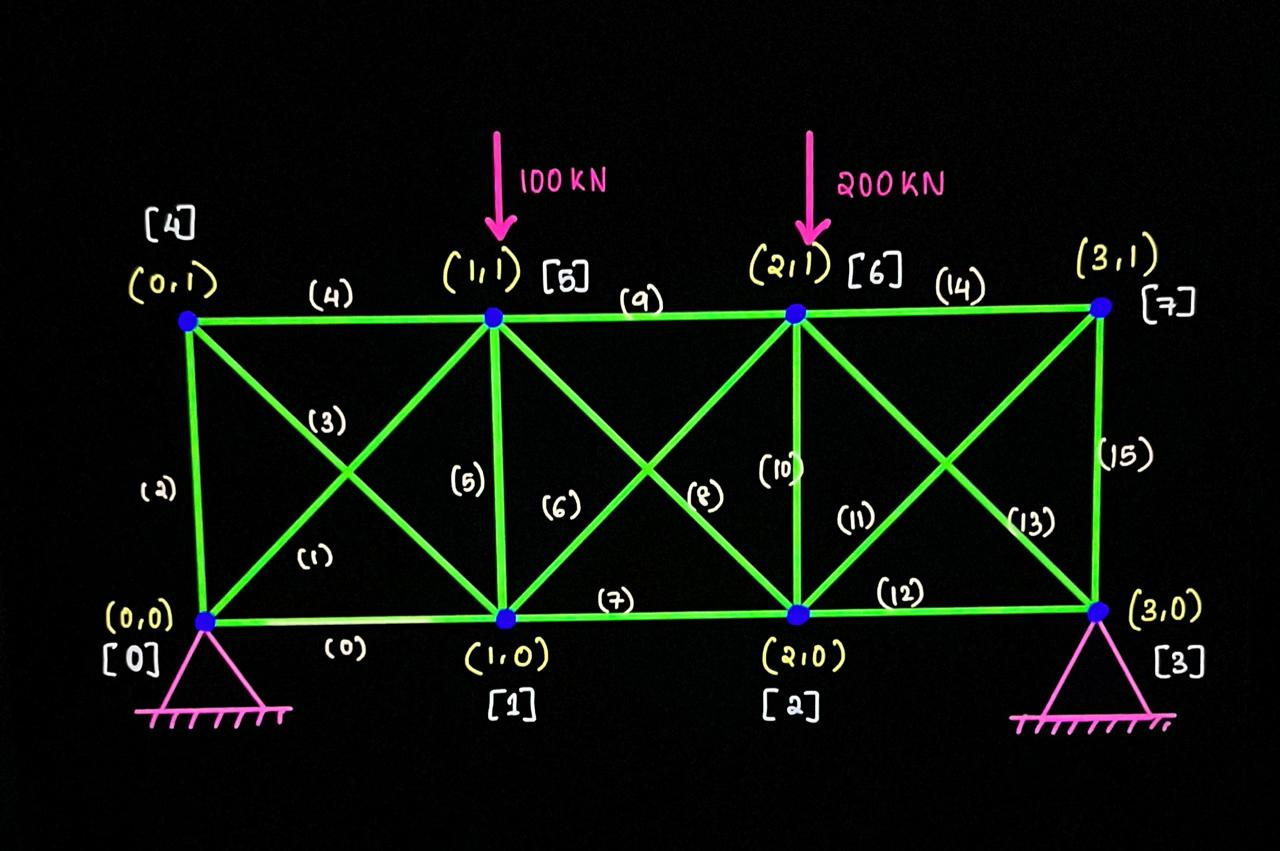

A diagram of the truss is above and we are going to use the same naming convention in the diagram as in the code

**Making the Truss**

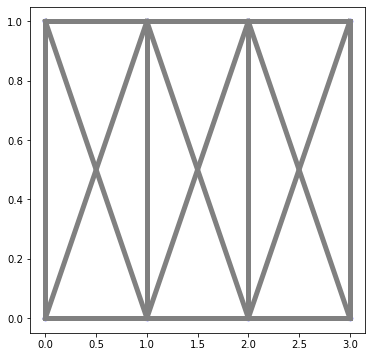

Truss structure


In [16]:
j = np.array([ [0.0,0.0],[1.0,0.0],[2.0,0.0],[3.0,0.0],[0.0,1.0],[1.0,1.0],[2.0,1.0],[3.0,1.0]])
m =np.array([[0,1],[0,5],[0,4],[1,4],[4,5],[1,5],[1,6],[1,2],[2,5],[5,6],[2,6],[2,7],[2,3],[3,6],[6,7],[3,7]],dtype=int)
E=2.1e11
A= np.pi * (2.5e-2)*(2.5e-2)
truss2 = amu.PlaneTruss(j, m, E, A)
truss2.plot(deformed=False) #reality check
print("Truss structure")

**Constraints and Loads**

In [17]:
constraint = [
        [0, 0, 0.0], #node 0 , directon 0 displacement =0.0
        [0, 1, 0.0], #node 0 , direction 1 disp =0.0
        [3, 0, 0.0], #node 3 direction 0 disp =0.0 
        [3, 1, 0.0]
      ]   
truss2.apply_constraints(constraint)

In [18]:
load = [
        [5,1,-1e5],
        [6,1,-2e5]
    
    ]
truss2.apply_loads(load)

In [19]:
truss2.solve()

**Deformed truss**

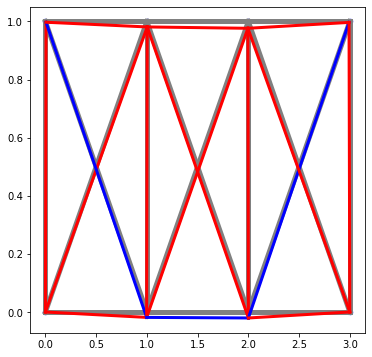

In [20]:
truss2.plot()

Now we need the deflection of joints 

In [21]:
truss2.dofs

array([ 4.74476147e-19,  4.64986261e-19, -8.67749501e-05, -7.45012220e-04,
        2.96120094e-05, -8.24498678e-04,  1.19691609e-19,  3.20407105e-20,
        2.49503190e-04, -1.06762926e-04,  1.42740264e-04, -7.55376161e-04,
       -1.65063781e-04, -9.39380890e-04, -2.95504372e-04, -1.30440591e-04])

so in a tabular format we can write it as 
$$
\begin{aligned}
& \text {Deflection of joints}\\
&\begin{array}{cccc}
\hline \hline \text { Coordinates } & \text { dx } & \text { dy }  \\
\hline 
(0,0)& 4.74476147e-19 &4.64986261e-19  \\
(1,0)& -8.67749501e-05&-7.45012220e-04\\
(2,0)& 2.96120094e-05 &-8.24498678e-04 \\
(3,0)& 1.19691609e-19 &3.20407105e-20  \\
(0,1)& 2.49503190e-04 &-1.06762926e-04 \\
(1,1)& 1.42740264e-04 &-7.55376161e-04  \\
(2,1)&-1.65063781e-04 &-9.39380890e-04 \\
(3,1)&-2.95504372e-04 &-1.30440591e-04 \\
\hline
\end{array}
\end{aligned}
$$

Now lets see the member forces 

In [22]:
print(truss2.member_forces)

[ -35780.26539059 -126305.31591953  -44021.98794673   62256.49239689
  -44021.98794673   -4273.40576123  -56212.98401183   47990.30474163
   -9072.53193273 -126918.08448117  -47369.84638835   76063.61114266
  -12210.03935104 -159638.64925286  -53785.09524051  -53785.09524051]


We can see the member forces ( positive is tensile ) on each memberof the truss and the ordering is according to member number and all of them are in **newton**

**Now lets see the reaction forces in a tabular format**

In [23]:
print(truss2.reactions)

[ 125091.6107772   133333.33333333 -125091.6107772   166666.66666667]


$$
\begin{aligned}
& \text {Reaction Forces}\\
&\begin{array}{cccc}
\hline \hline \text { Support } & \text { R_x } & \text { R_y }  \\
\hline 
\text{Fixed support at}(0,0) &125091.6107772N &133333.33333333N \\
\text{Fixed support at}(3,0) &-125091.6107772N &166666.66666667N \\
\hline
\end{array}
\end{aligned}
$$

### Part 3:
If we observe the deflections of the joints the are of maximum order of $10^{-4}$ m and the dimentions of the rods or members are of the order $10^0$ and if we model the rotation of the rods , we can see that the tan of the angular deflection $\delta$ ,  $tan(\delta)$ ~ $\frac{\Delta r_{joint}}{L_{rod}} $ ~ $10^{-4}$ , which is a considerably small value and we know that for small values $tan^{-1}(x) = \mathcal{O}(x)$ , Hence angular deflections of the members are of the order $10^{-4}$ which is too small to be a significant issue in our computations so we can assume that the angle between truss members remain **almost** _same_ .

In [50]:
joint_2 = j + 0
d = truss2.dofs
dxdy=np.array([[d[0],d[1]]
               ,[d[2],d[3]]
               ,[d[4],d[5]]
               ,[d[6],d[7]]
               ,[d[8],d[9]]
               ,[d[10],d[11]]
               ,[d[12],d[13]]
               ,[d[14],d[15]]
              ])
truss_d = amu.PlaneTruss(joint_2 + dxdy, m, E, A)
print("Angular deflections")
print(truss_d.compute_angles()-truss2.compute_angles())


Angular deflections
[ 7.45076736e-04 -4.49195779e-04 -2.49529825e-04 -4.87190120e-04
  6.48682400e-04 -2.29517589e-04 -5.80478330e-05  7.94772078e-05
 -9.11273905e-05  1.84061382e-04  1.94698156e-04  5.09493204e-04
  8.24522907e-04  5.52436160e-04  8.09045655e-04  2.95542914e-04]


As we have predicted , we can see that the angular deflections are of the order of $10^{-4}$ radians and we have computed the deflections by creating a dummy matrix with default added deformations and subtracted the angle between members and our estimate matches the computed value

### Part 4:
If we analyse the displacement of the joints esp ones at (0,0) and (3,0) , we can see that they are of the order of $10^{-19}$ which is sufficiently small enough to be counted as zero as those two joints are fixed supports and in the other joints , displacement vectors are single valued hence indicating the validity of constraints in which the member rods deform or move. Hence for this truss , the constraint equations for each joint are satisfied.
Now the main contstraint is the displacement perpendicular to rods is zero. Now lets verify this :

In [66]:
ang = truss2.compute_angles()
ds = truss2.dofs
def member_check(n):
    rod = m[n]
    one=rod[0]
    two=rod[1]
    theta = ang[n]
    jthet1= np.angle(ds[2*one] + ds[2*one + 1]*(1j))
    jthet2= np.angle(ds[2*two] + ds[2*two + 1]*(1j))
    return [np.cos(theta - jthet1) , np.cos(theta - jthet2)]
for i in range(11):
    print(member_check(i))

[0.7142131119359058, -0.11569241631014528]
[0.9999489847642739, -0.5635150070414356]
[0.6999283039989378, -0.39339932137643396]
[-0.62055172883198, -0.9282664652934999]
[0.9193677033377674, 0.18567974922854563]
[-0.9932850873784022, -0.9826103147873141]
[-0.7841655130415015, -0.8188117087630682]
[-0.11569241631014528, 0.03589202799076619]
[-0.7320306699920758, -0.8261058266584802]
[0.18567974922854563, -0.17306405204339817]
[-0.9993556735850906, -0.9849105715192217]


the above is the cosines of the deflection of joints with the member alignment vector <br>
member n  --> $1^{st}$ joint cosine , $2^{nd}$ joint cosine <br>
member number vary from n = 0 to 10

As we can see the components of displacement of each joints are not perpendicular to the members of the truss conected to the truss but since the displacements are small , the perpendicular components themselves are small , but this non perpendicularity is the major cause for angular deflection.

### Part 5:
If we see the results of truss2.plot() , we can see that most of the rods are in compressive stress so buckling will be a major issue and we know that the formula for buckling stress is 
$${\sigma}_{b} = \dfrac{\pi^2 E I}{L^2}$$ which means higher the area moment , Lower the chance of buckling so changing the shape of cross section keeping area constant will have great impact on the buckling limits. The area moment of square and circle of same area are as below:
$$I_{square} = \frac{(\sqrt{pi}R)^4}{12} = \frac{\pi^2}{12}R^4$$
$$I_{circle}=\frac{\pi}{4}R^4$$ where R is the radius of the circle and clearly since $\frac{\pi^2}{12}$ > $\frac{\pi}{4}$ , Square has larger area moment about centroidal or buckling axis , making the truss with square cross sectioned members more immune towards bucking than those with circular cross section of same area. In case of deformations and tensile breaking stresses , we can see that there is no difference between these two so both are equally stiff in that sense.

Truss Loads and Deformation


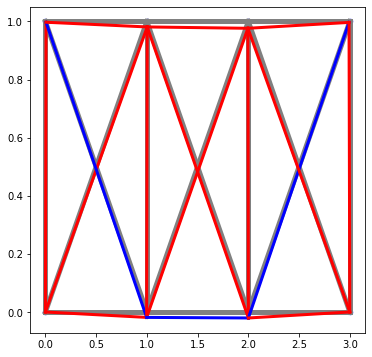

In [52]:
print("Truss Loads and Deformation")
truss2.plot()
